# Pilot Points Run

In this notebook we are going to calibrate the Freyberg model with pilot points as the parameterisation device for hydraulic conductivity. We are using the same PEST control file constructed in the "freyberg pilotpoints setup" notebook. 

 
### Admin
We have provided some pre-cooked PEST dataset files, wraped around the modified Freyberg model. This is the same dataset introduced in the "freyberg_pest_setup" and subsequent notebooks. We pick up here after the "freyberg pilotpoints setup" notebook.

The functions in the next cell import required dependencies and prepare a folder for you. This folder contains the model files and a preliminary PEST setup. Run the cells, then inspect the new folder named "freyberg_mf6" which has been created in your tutorial directory. (Just press `shift+enter` to run the cells). 

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import psutil
import shutil

sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
# a dir to hold a copy of the org model files
tmp_d = os.path.join('freyberg_mf6')
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)
# get executables
hbd.prep_bins(tmp_d)
# get dependency folders
hbd.prep_deps(tmp_d)
# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(tmp_d)

ins file for heads.csv prepared.
ins file for sfr.csv prepared.
noptmax:0, npar_adj:1, nnz_obs:24
written pest control file: freyberg_mf6\freyberg.pst


### Run the non-pilot point setup
Just so we can compare; its quite quick so no worries.

In [3]:
pst_base = pyemu.Pst(os.path.join(tmp_d,'freyberg.pst'))
pst_base.control_data.noptmax=20
par = pst_base.parameter_data
par.loc['rch0', 'partrans'] = 'log'
obs = pst_base.observation_data
obs.loc[(obs.obgnme=="gage-1") & (obs['gage-1'].astype(float)<=4018.5), "weight"] = 0.005
pst_base.write(os.path.join(tmp_d, 'freyberg.pst'))
pyemu.os_utils.run("pestpp-glm freyberg.pst", cwd=tmp_d)

noptmax:20, npar_adj:2, nnz_obs:37


In [4]:
pst_base = pyemu.Pst(os.path.join(tmp_d,'freyberg.pst'))
assert pst_base.phi

Recall what phi we achieve usgin homogneous `hk1` and `rch0`:

In [5]:
pst_base.phi

61.144289680170665

Let's see if we can beat that.

### Now run the pilot point setup

Load the PEST control file set up with pilot point parameters:

In [6]:
# convenience function that builds a new control file with pilot point parameters for hk
hbd.add_ppoints(tmp_d)

   could not remove start_datetime
1 pars added from template file .\freyberg6.sfr_perioddata_1.txt.tpl
6 pars added from template file .\freyberg6.wel_stress_period_data_10.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_11.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_12.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_2.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_3.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_4.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_5.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_6.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_7.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_8.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_9.txt.tpl
starting interp point loop for 800 points
took

Load the control file with pilot point parameters:

In [7]:
pst = pyemu.Pst(os.path.join(tmp_d,'freyberg_pp.pst'))

We (the authors) have added a few more parameters in the background. These include well pumping rates and STR inflow:

In [8]:
pst.adj_par_groups

['strinf', 'wel', 'hk1', 'rchpp']

As usual, run once to check that it works (trust but verify!):

In [9]:
pst.control_data.noptmax=0
pst.write(os.path.join(tmp_d, 'freyberg_pp.pst'))

pyemu.os_utils.run("pestpp-glm freyberg_pp.pst", cwd=tmp_d)

noptmax:0, npar_adj:65, nnz_obs:37


Check if it completed sucessfully:

In [10]:
pst = pyemu.Pst(os.path.join(tmp_d, 'freyberg_pp.pst'))
assert pst.phi

Right then, let's increase NOPTMAX and start parameter estimation:

In [11]:
pst.control_data.noptmax = 8

Always remember to re-write the control file!

In [12]:
pst.write(os.path.join(tmp_d, 'freyberg_pp.pst'))

noptmax:8, npar_adj:65, nnz_obs:37


OK, good to go.

Now, when using derivative-based methods such as are implemented in PEST++GLM (and PEST/PEST_HP) the cost of more adjustable parameters is ...more run-time. Recall that PEST(++) needs to run the model the same number of times as there are adjustable parameters in order to fill the Jacobian matrix.

We just went from having 2 adjustable paramters to having 30. So this is going to take quite a bit longer. 

Up until now, we have been running a single instance of `pestpp-glm`. Now, we are going to run `pestpp-glm` in parallel. 

To speed up the process, you will want to distribute the workload across as many parallel agents as possible. Normally, you will want to use the same number of agents (or less) as you have available CPU cores. Most personal computers (i.e. desktops or laptops) these days have between 4 and 10 cores. Servers or HPCs may have many more cores than this. Another limitation to keep in mind is the read/write speed of your machines disk (e.g. your hard drive). PEST and the model software are going to be reading and writting lots of files. This often slows things down if agents are competing for the same resources to read/write to disk.

The first thing we will do is specify the number of agents we are going to use.

### Attention!

You must specify the number which is adequate for ***your*** machine! Make sure to assign an appropriate value for the following `num_workers` variable. (If you are unsure how many cores you have, you can use `psutil` to check).

In [13]:
psutil.cpu_count(logical=False)

10

In [14]:
# set the number of parallel agents
num_workers = 6

Next, we shall specify the PEST run-manager/master directory folder as `m_d`. This is where outcomes of the PEST run will be recorded. It should be different from the `t_d` folder, which contains the "template" of the PEST dataset. This keeps everything separate and avoids silly mistakes.

In [15]:
m_d='master_pp'

The following cell deploys the PEST agents and manager and then starts the run using `pestpp-glm`. Run it by pressing `shift+enter`.

If you wish to see the outputs in real-time, switch over to the terminal window (the one which you used to launch the `jupyter notebook`). There you should see `pestpp-glm`'s progress written to the terminal window in real-time. 

If you open the tutorial folder, you should also see a bunch of new folders there named `worker_0`, `worker_1`, etc. These are the agent folders. The `m_d` folder is where the manager is running. 

This run should take several minutes to complete (depending on the number of workers and the speed of your machine). If you get an error, make sure that your firewall or antivirus software is not blocking `pestpp-glm` from communicating with the agents (this is a common problem!).

> **Pro Tip**: Running PEST from within a `jupyter notebook` has a tendency to slow things down and hog alot of RAM. When modelling in the "real world" it is more efficient to implement workflows in scripts which you can call from the command line.

In [16]:
pyemu.os_utils.start_workers(tmp_d, # the folder which contains the "template" PEST dataset
                            'pestpp-glm', #the PEST software version we want to run
                            'freyberg_pp.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

## Outcomes

Re-load the control file and check the new Phi:

In [17]:
pst = pyemu.Pst(os.path.join(m_d, 'freyberg_pp.pst'))
assert pst.phi!=pst_base.phi
pst.phi

4.303617832268006

Sweet - we did way better! More parameters means more "flexibility" for PEST to obtain a better fit:

In [18]:
pst.phi / pst_base.phi

0.07038462389176607

Check out the Phi progress. Not too bad. Looks like PEST could still do better if we let it carry on.

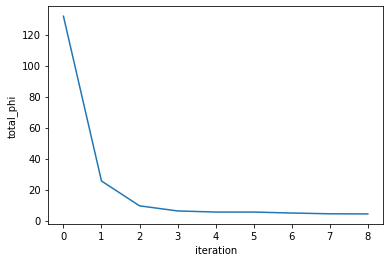

In [19]:
df_obj = pd.read_csv(os.path.join(m_d,"freyberg_pp.iobj"),index_col=0)
df_obj.total_phi.plot()
plt.ylabel('total_phi');

What about the fits with measured values? Doing better than before, for sure. Not perfect, but pretty good.

 > (side note: recall we "conveniently" didn't add pilot points for recharge as well...not to mention all the other poorly known or unknowable parameter values...pumping rates, storage parameters, GHB parameters, aquifer geometry...etc, etc...perhaps we should have?)

<Figure size 576x756 with 0 Axes>

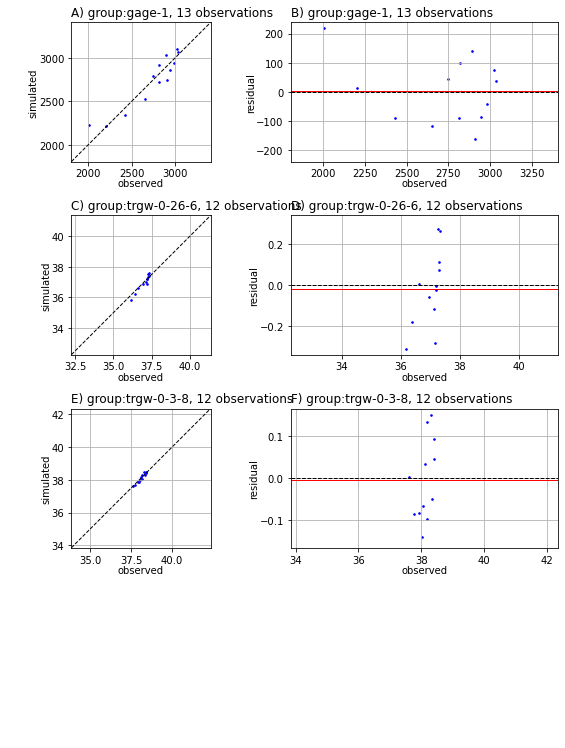

In [20]:
figs = pst.plot(kind="1to1");

Let's inspect the posterior parameter uncetanties for each group of pilot points (`hk1` and `rchpp`). The next cell plots the prbability distribution for each parameter in each parameter group. Recall that each pilot point is assigned a unique parmaeter, so in each plot we are displaying 30 distributions. We are also plotting the parmater upper and lower bounds as vertical dashed black lines.

In [21]:
pst.adj_par_groups

['strinf', 'wel', 'hk1', 'rchpp']

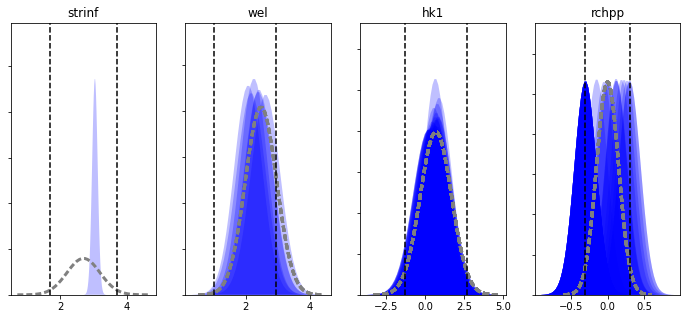

In [22]:
par = pst.parameter_data
df_paru = pd.read_csv(os.path.join(m_d,"freyberg_pp.par.usum.csv"),index_col=0)

fig, axes=plt.subplots(1,len(pst.adj_par_groups),figsize=(12,5))
i=0
for pargp in pst.adj_par_groups:
    ax = axes[i]
    i+=1
    pars = par.loc[par.pargp==pargp].parnme.values
    df_par = df_paru.loc[pars,:]
    ax = pyemu.plot_utils.plot_summary_distributions(df_par,label_post=False, ax=ax)
    mn = np.log10(pst.parameter_data.loc[pars[0].lower(),"parlbnd"])
    mx = np.log10(pst.parameter_data.loc[pars[0].lower(),"parubnd"])
    ax.set_title(pargp)
    ax.plot([mn,mn],ax.get_ylim(),"k--")
    ax.plot([mx,mx],ax.get_ylim(),"k--")

Yikes - that doesn't look good. Lots of parameters are right up againts the bounds. (The center of the distributions is centered on the black lines.) This implies that they are taking on exteme values in order to achieve that "excelent" fit with measured data. 

Is this realistic? No, not really. It often means parameters are taking on compensatory roles to make up for strucutural error or poor conceptualization.

Another noteworthy aspect is that `rchpp` parameters have deviated from the prior. But most of the `hk1` parameters have not changed much. Why do you think this is? Usually we assume that we are more confident that we "know" recharge better than hydraulic conductivity. After all, hydraulic conductivity can vary by orders of magnitude, whislt recharge is usually only expected to vary within an order of magnitude (_big ugly rule of thumb alert!_).

Let's take a look at the calibrated parameter field. First we just need to update the model files with the calibrated parameter values:

In [23]:
pst.parrep(os.path.join(m_d, "freyberg_pp.par" ))
pst.write_input_files(pst_path=m_d)
pyemu.geostats.fac2real(os.path.join(m_d,"hkpp.dat"),
                        factors_file=os.path.join(m_d,"hkpp.dat.fac"),
                        out_file=os.path.join(m_d,"freyberg6.npf_k_layer1.txt"))

Updating parameter values from master_pp\freyberg_pp.par
parrep: updating noptmax to 0


'master_pp\\freyberg6.npf_k_layer1.txt'

In [24]:
pyemu.os_utils.run('python forward_run.py', cwd=m_d)

And then use `flopy` to plot:

In [25]:
df_pp = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(m_d,"hkpp.dat.tpl"))
sim = flopy.mf6.MFSimulation.load(sim_ws=m_d, verbosity_level=0) #modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=[])
gwf= sim.get_model()

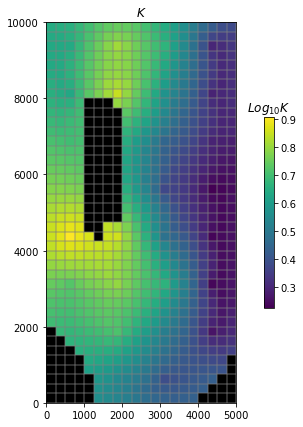

In [26]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)

k = gwf.npf.k.get_data()
ca = mm.plot_array(np.log10(k), masked_values=[1e30],)
cb = plt.colorbar(ca, shrink=0.5)
cb.ax.set_title('$Log_{10}K$')

mm.plot_grid(alpha=0.5)
mm.plot_inactive()
ax.set_title('$K$');

How does that compare to the true values? The patterns are not very similar...and those "bulls-eyes" in the calibrated field don't look very realistic.

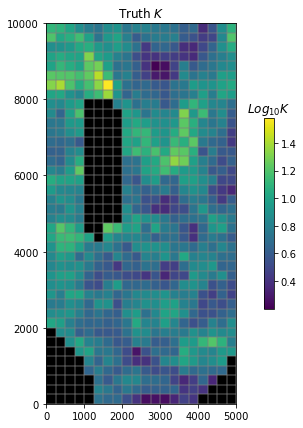

In [27]:
gwf = hbd.plot_truth_k(m_d)

Something is wrong... We better checkout the forecasts:

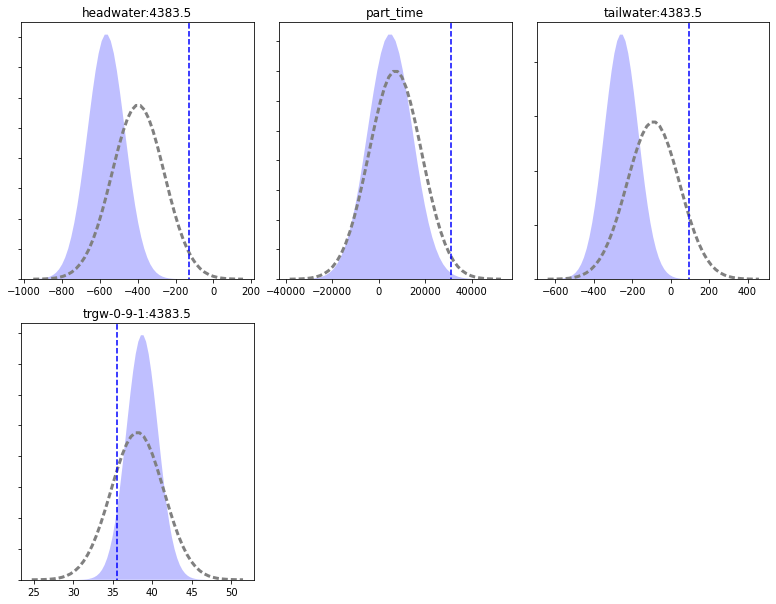

In [28]:
figs, axes = pyemu.plot_utils.plot_summary_distributions(os.path.join(m_d,
                    "freyberg_pp.pred.usum.csv"),subplots=True, )
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"b--")
    ax.set_ylim(0, ylim[-1])
figs[0].tight_layout()

Sheesh! What happened? We are still failing to capture many of our forecast "truths" in the posterior. The answer: overfitting. We specified lots of parameters, so we are able to fit the observations really well - too well.  

Even though we are able to measure water levels very precisely, the model has problems (model error, also referred to as structural error), so we shouldn't expect the model to reproduce the observations so well.  So how do we control this overfitting? 

The last few tutorials have shown us a few things:
 - Having more parameters than observations allows us to have an overdetermined, and therefore solvable, inverse problem. But! It under-represents uncertainty. Using few parameters will by default fail to capture nuances of properties and processes of a complex real world system. 
 - More parameters introduces more flexibility. This can mean better fits with calibration data. It also may mean more uncertainty. (This leads to an often touted falacy that a model should "use fewer parameters to have less uncertainty". Doing so doesn't reduce uncertainty. It merely ignores it.) 
 - But more parameters also means more problems. 
     - Parameters may be correlated, resulting in non-unique solutions to the inverse problem. 
     - But more parameters than observations results in an ill-posed inverse problem. We might be able to achive excelent fits with obsevration data, but this comes at the costof "unreasoanble" parameter values (e.g. overfitting). 
     
So how can we use many parameters and avoid overfitting? Enter "regularization". Stick around for the next episode.